In [1]:
import sys
sys.path.append("../../smsl")

In [2]:
from smsl.multiWindows import SmallTimeAgent
from smsl.config import ConfAgent
from smsl.graph import PR0
from smsl.plotAgent import SinglePlotAgent, palette

In [3]:
import os
import pandas as pd
import numpy as np

In [4]:
class HotSpotAgent(dict, ConfAgent):
    def __init__(self, MAgent):
        ConfAgent.__init__(self)
        self.end_ns = self.time_num
        self.framesperns = self.frame_num // self.time_num
        self.MAgent = MAgent
    def load_systems(self, system2offical_name):
        ori_path = os.getcwd()
        for system, system_offical_name in system2offical_name.items():
            os.chdir(f'../../{system}/d.fluctmatch')
            st_agent = HsSmallTimeAgent(0, self.end_ns, self.framesperns, self.MAgent)
            st_agent.system_offical_name = system_offical_name
            self[system] = st_agent
        os.chdir(ori_path)
        self.m_abbr = st_agent.st_agent.m_abbr
    def extend_rirjs(self):
        for system, st_agent in self.items():
            st_agent.extend_rirjs()


class HsSmallTimeAgent(SmallTimeAgent):
    def __init__(self, beg_ns, end_ns, framesperns, MAgent):
        SmallTimeAgent.__init__(self, beg_ns, end_ns, framesperns)
        self.st_agent = MAgent(0, self.end_ns, self.framesperns)
        self.df_m = self.st_agent.df_m
    def get_rirjs(self, is_return=False):
        rirjs_str, rirjs = [], []
        seq_strand1 = self.strandid2sequence['STRAND1']
        for ri in range(1, self.n_bp+1):
            rirjs_str.append(f'{seq_strand1[ri]}{ri}')
            rirjs.append([ri, ri])
        if is_return:
            return rirjs_str, rirjs
        else:
            self.rirjs_str = rirjs_str
            self.rirjs     = rirjs

    def extend_rirjs(self, df_m=None):
        self.get_rirjs()
        if df_m is None:
            df_m = self.df_m
        for rirj_str, (ri, rj) in zip(self.rirjs_str, self.rirjs):
            df_sele = df_m.query(f'Resid_i=={ri} & Resid_j=={rj}')
            df_m.loc[df_sele.index, ['aiaj']] = df_sele['Atomname_i'] + df_sele['Atomname_j']
            df_m.loc[df_sele.index, ['rirj']] = rirj_str

In [5]:
system2offical_name = {
'propeller': 'Propeller',
'basket'   : 'Basket',
'chair'    : 'Chair',
'hybrid-i' : 'Hybrid-I',
'hybrid-ii': 'Hybrid-II',
'dsdna'    : 'dsDNA',
}

hs_agent = HotSpotAgent(PR0)
hs_agent.load_systems(system2offical_name)
hs_agent.extend_rirjs()

Reading data from: /home/user/workfolder/g4dna_protocol_demo/propeller/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/basket/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/chair/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/hybrid-i/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/hybrid-ii/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

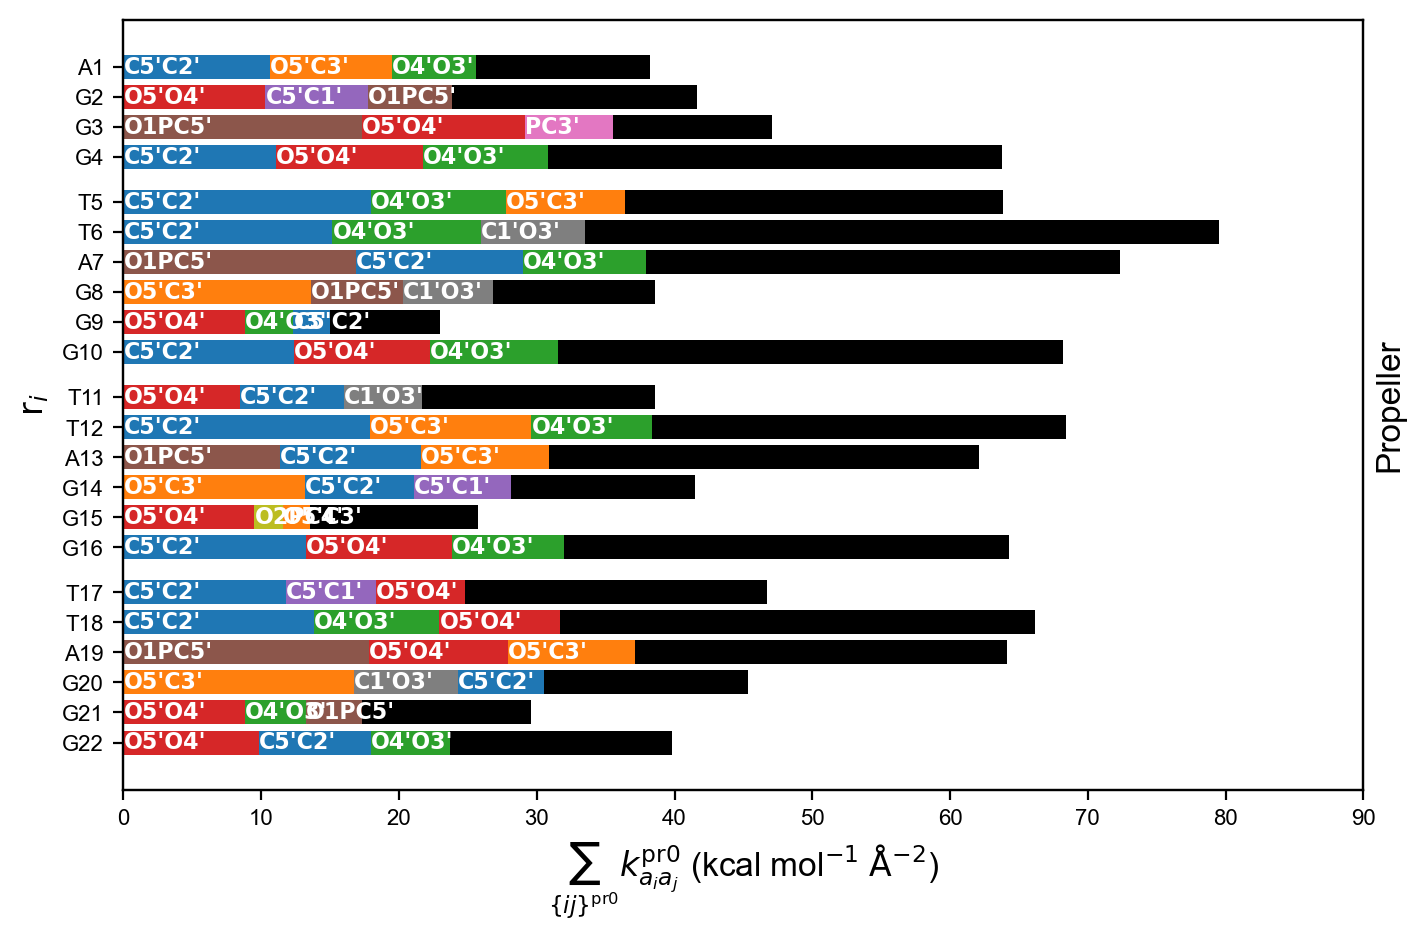

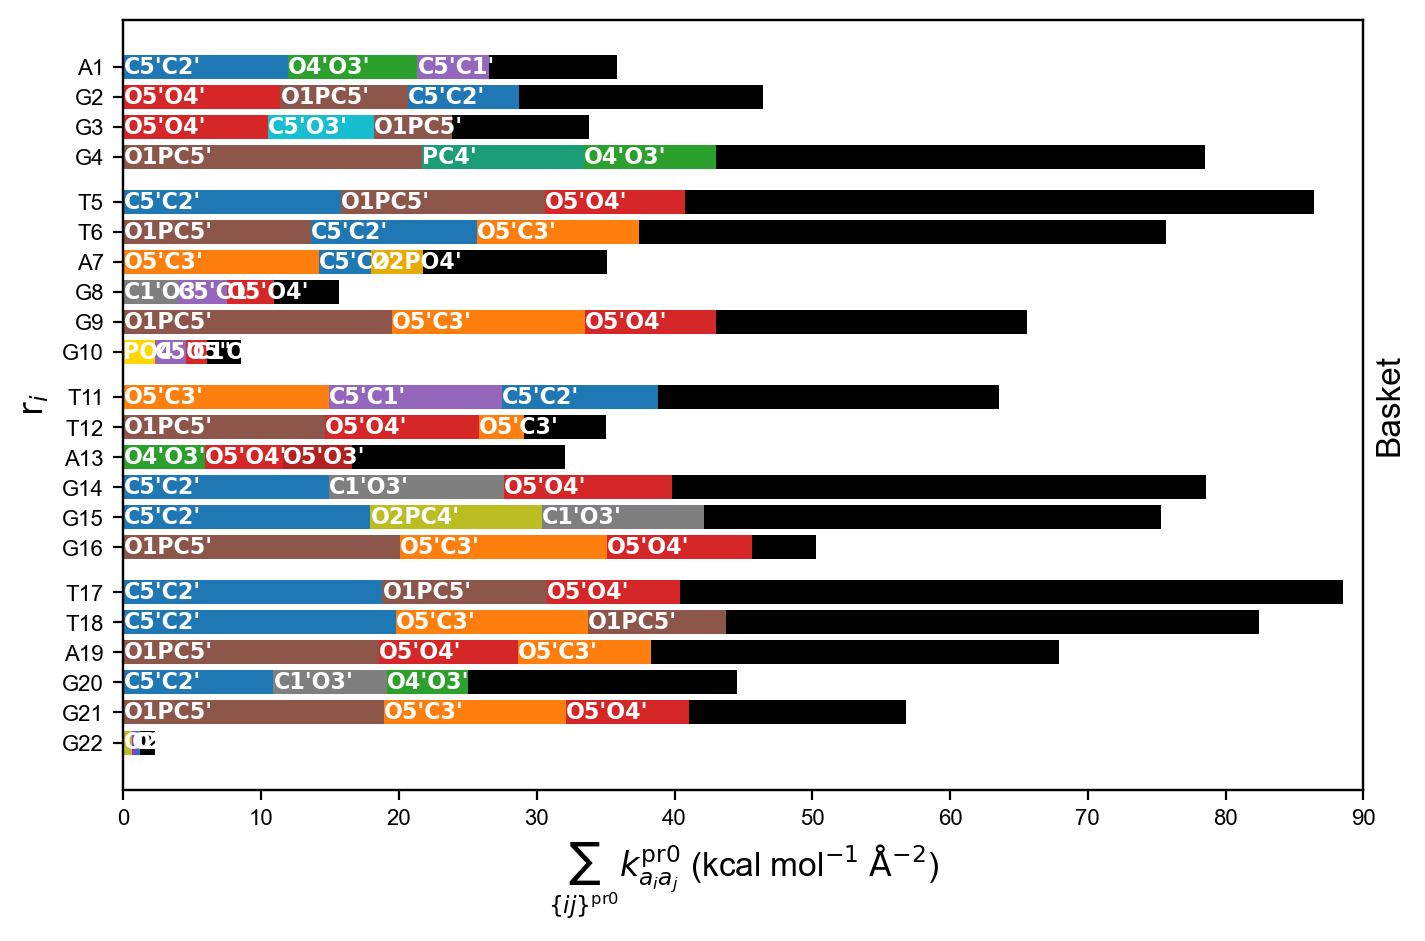

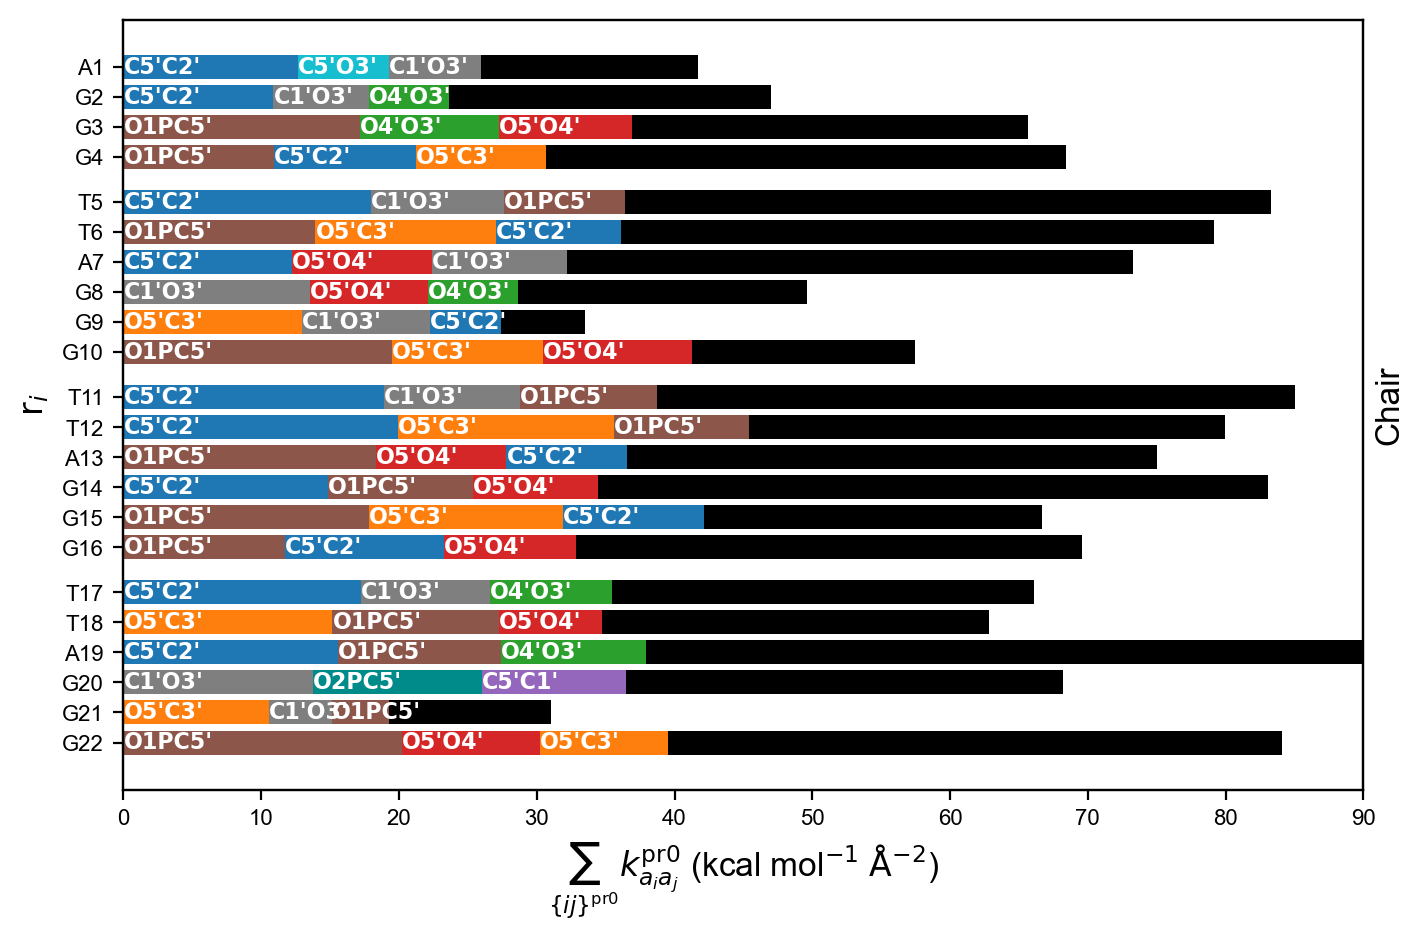

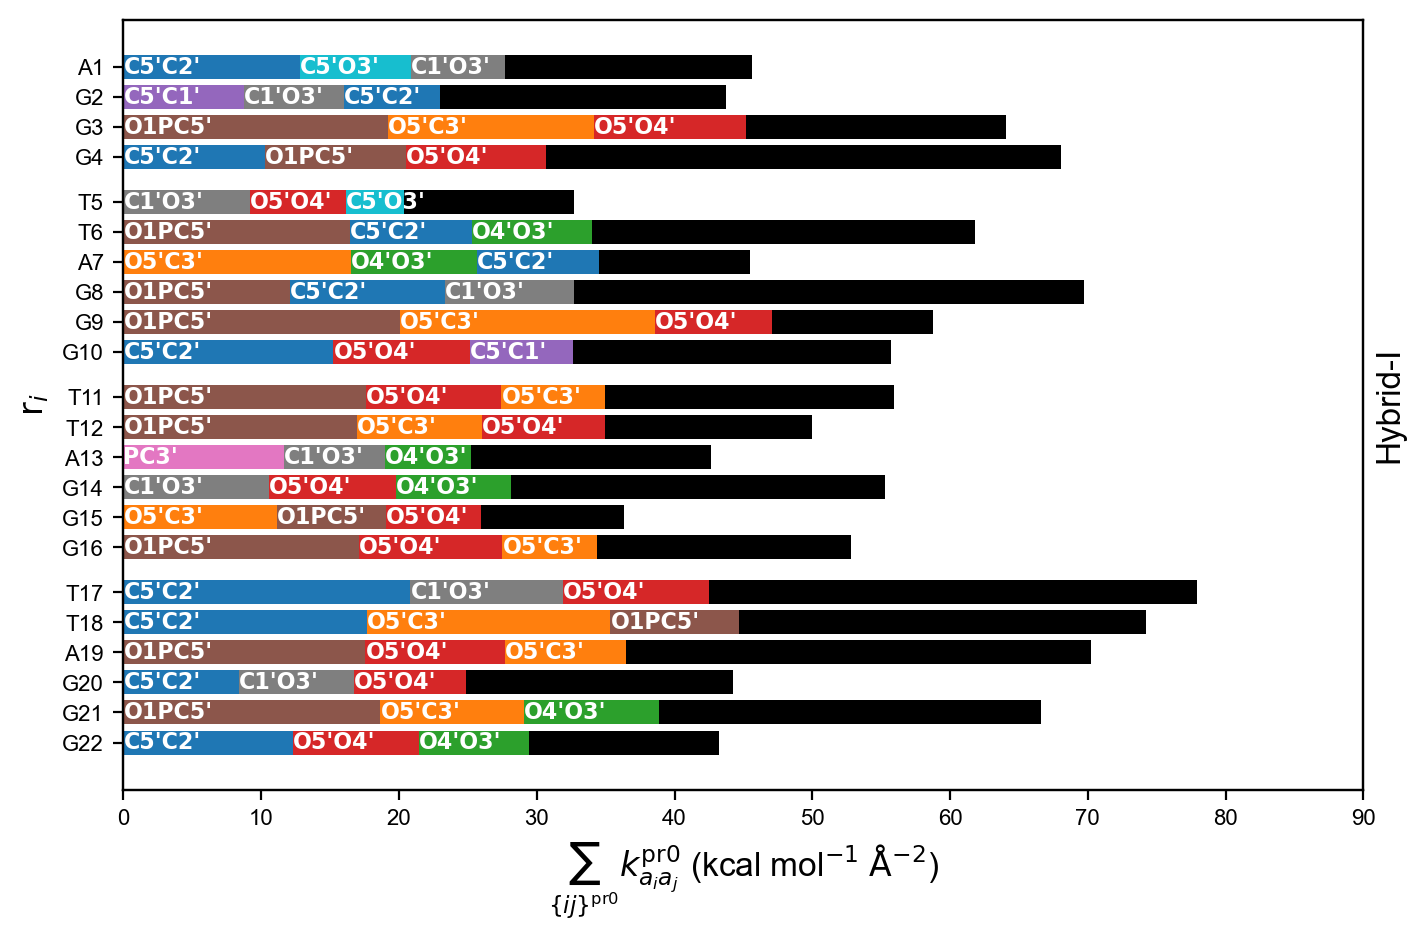

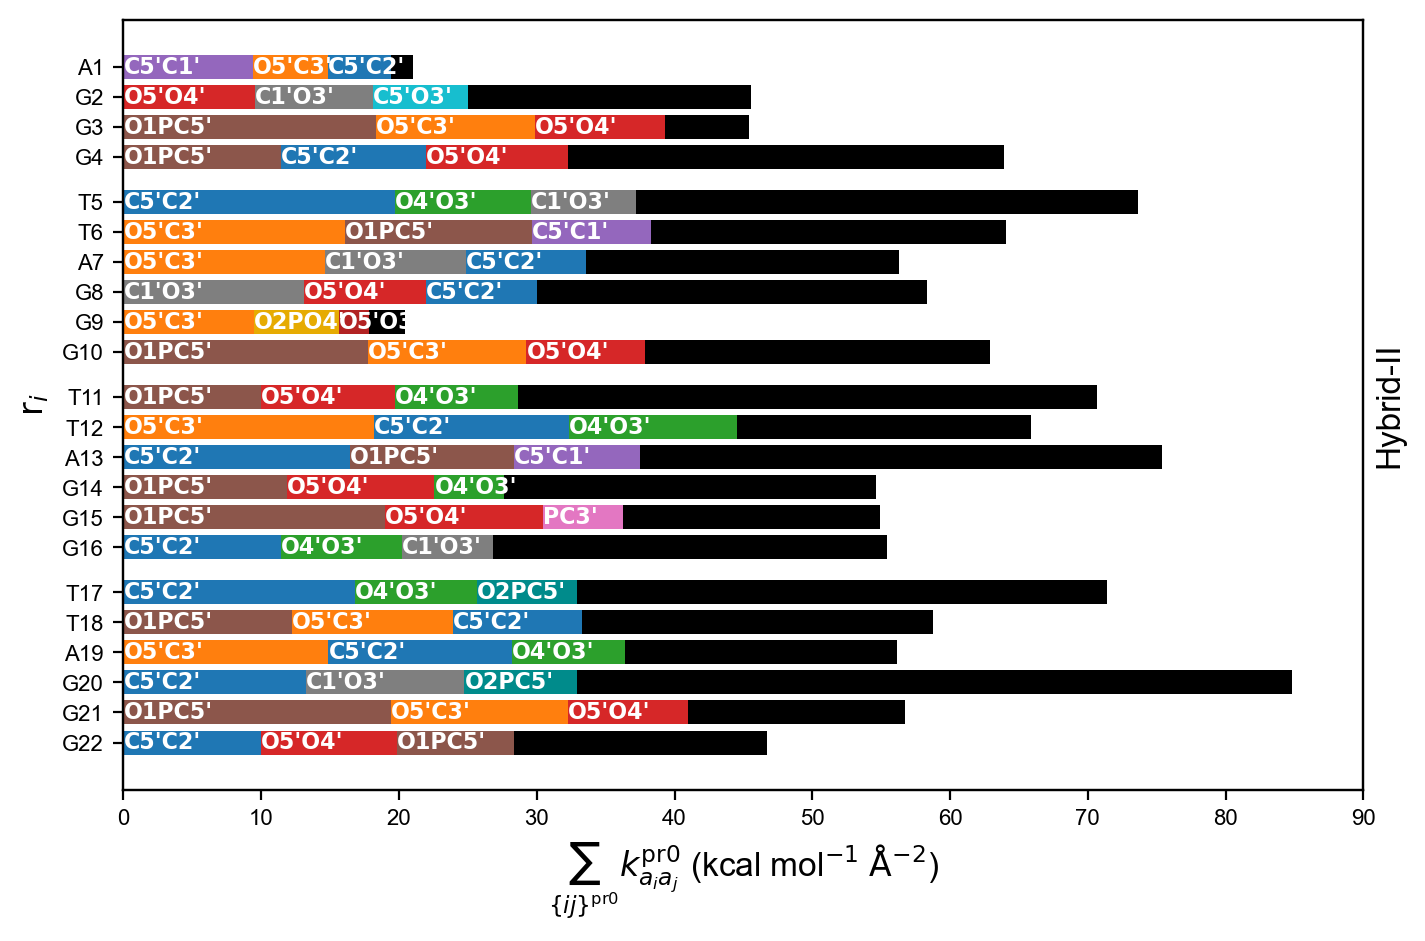

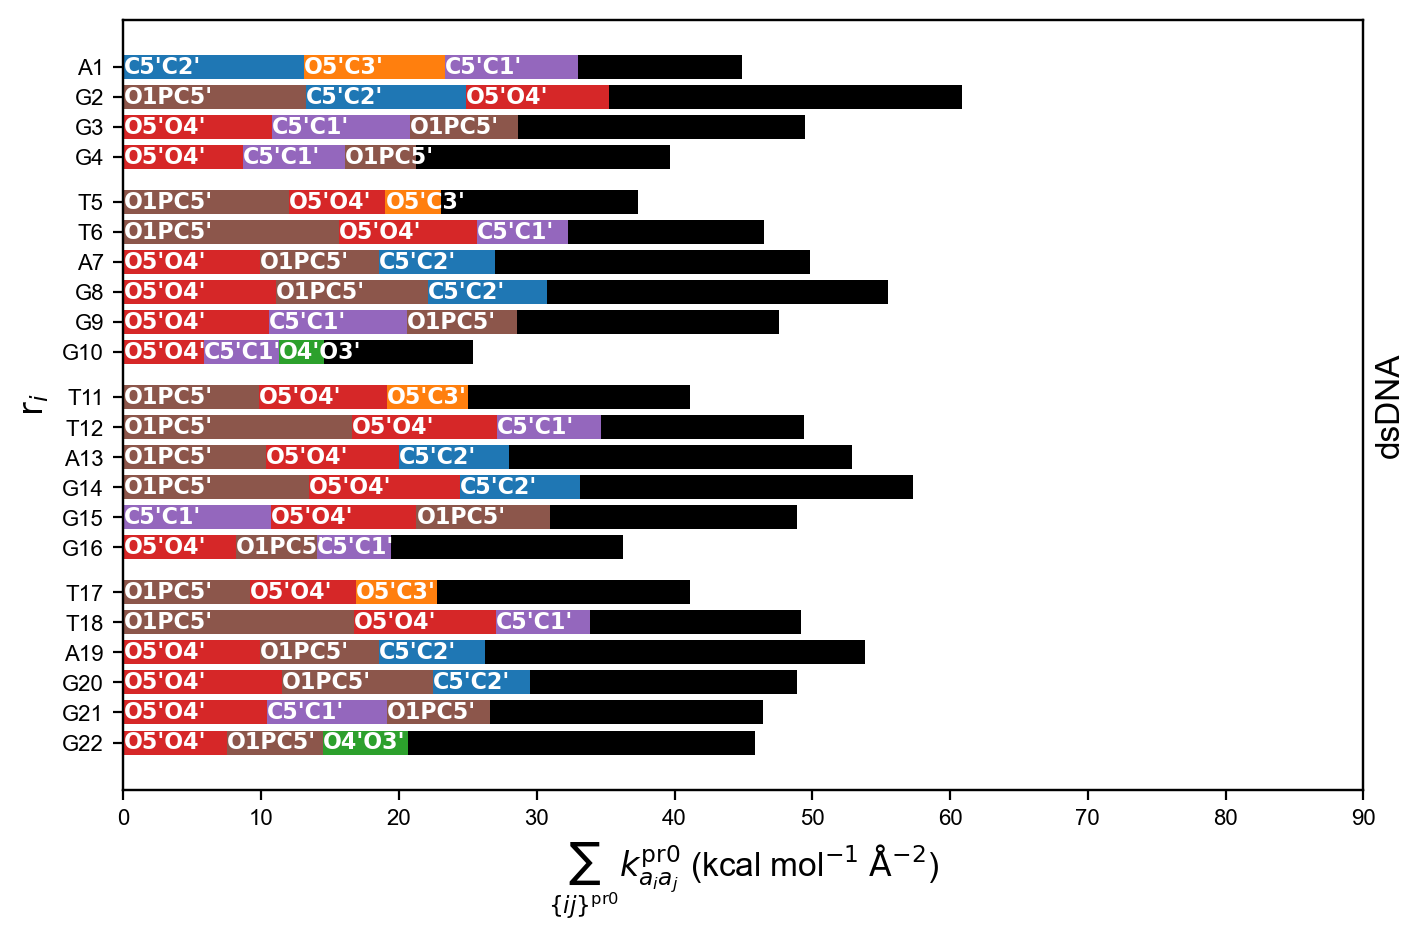

In [6]:
n_top = 3

aiaj2color = {}
for system, st_agent in hs_agent.items():
    p_agent = SinglePlotAgent(figsize_1=[8.0, 5.0])

    # Initialize left for each category
    n_repeat = (4,6)
    lefts = {rirj_str: 0 for rirj_str in st_agent.rirjs_str}
    yticks = np.arange(0.0, len(st_agent.rirjs_str))[::-1]
    for y in range(n_repeat[0], len(yticks), n_repeat[1]):
        yticks[:y] = yticks[:y] + 0.5
    rirj2ytick = dict(zip(st_agent.rirjs_str, yticks))

    # Sort the DataFrame by 'p' and 'k' (descending)
    df_sorted = st_agent.df_m.sort_values(by=['rirj', 'k'], ascending=[True, False])

    # Plot data
    for rirj_str in st_agent.rirjs_str:
        # Filter sorted data for the current category
        df_sele = df_sorted[df_sorted['rirj'] == rirj_str]
        # Plot each segment with the cumulative left position
        for i, (_, df_iter) in enumerate(df_sele.iterrows()):
            if i >= n_top: 
                aiaj = ''
                color = 'black'
            else:
                aiaj = df_iter['aiaj']
                color = aiaj2color.get(aiaj)
                if color is None:
                    color = palette[len(aiaj2color)]
                    aiaj2color[aiaj] = color
                    p_agent.axs.plot([], [], label=aiaj, c=color)
            ## barplot
            p_agent.axs.barh(rirj2ytick[df_iter['rirj']], df_iter['k'], left=lefts[rirj_str], color=color)
            ## text
            x = lefts[rirj_str]
            y = rirj2ytick[df_iter['rirj']]
            # print(df_iter['k'], x)
            p_agent.axs.text(x, y, aiaj, ha='left', va='center', c='white', rotation=0, 
                             size=8, fontweight='bold', alpha=1.0)
            # Update left position for the next segment
            lefts[rirj_str] += df_iter['k']
    # print(lefts)

    # Add labels, title, and legend
    p_agent.set_xlabel(r'$\sum_{\{ij\}^{\rm{'+hs_agent.m_abbr+r'}}} k^{\rm{'+hs_agent.m_abbr+'}}_{a_ia_j}$'+r' (kcal mol$^{-1}$ $\rm{\AA}^{-2}$)', fontdict={'family': 'Arial', 'weight': 'normal', 'size': 12})
    p_agent.axs.set_ylabel(r'${\rm{r}}_{i}$', fontdict={'family': 'Arial', 'weight':'normal', 'size': 12})
    p_agent.set_ylabel(st_agent.system_offical_name, position='right')
    xticks = range(0, 91, 10)
    p_agent.set_xticks(xticks, fontdict={'family': 'Arial', 'weight': 'normal', 'size': 8})
    p_agent.axs.set_yticks(yticks)
    p_agent.axs.set_yticklabels(st_agent.rirjs_str, fontdict={'family': 'Arial', 'weight': 'normal', 'size': 8})
    p_agent.savefig(f'{hs_agent.m_abbr}_stacked_barplot.{st_agent.system_offical_name}.svg')

../../smsl/smsl/plotAgent.py:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels, fontdict=fontdict, rotation=rotation)
../../smsl/smsl/plotAgent.py:129: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels, fontdict=fontdict)


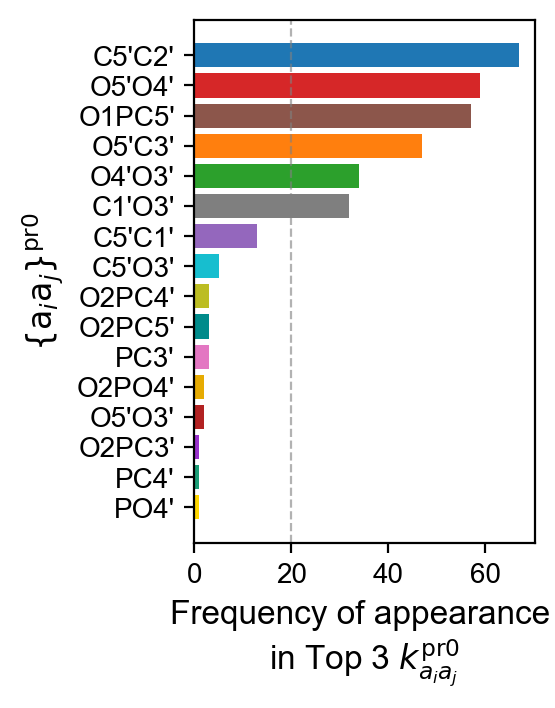

In [7]:
n_top = 3

## Create DataFrame
aiaj_list = []
for system, st_agent in hs_agent.items():
    if system=='dsdna': continue
    # Sort the DataFrame by 'rirj' and 'k' (descending)
    df_sorted = st_agent.df_m.sort_values(by=['rirj', 'k'], ascending=[True, False])
    # Plot data
    for rirj_str in st_agent.rirjs_str:
        # Filter sorted data for the current category
        df_sele = df_sorted[df_sorted['rirj'] == rirj_str]
        aiaj_n_top = df_sele['aiaj'][:n_top]
        aiaj_list.extend(list(aiaj_n_top))
df_aiaj_count = pd.DataFrame(np.unique(aiaj_list, return_counts=True),index=['aiaj', 'count']).T.sort_values(by='count', ascending=False)

## Plot Figure
p_agent = SinglePlotAgent(figsize_1=[2.2, 3.4])
for idx, df_iter in df_aiaj_count.iloc[::-1,:].iterrows():
    p_agent.axs.barh(df_iter['aiaj'], df_iter['count'], color=aiaj2color[df_iter['aiaj']])
p_agent.set_xlabel(f'Frequency of appearance \nin Top {n_top} ' + r'$k^{\rm{'+hs_agent.m_abbr+r'}}_{a_ia_j}$')
p_agent.set_ylabel(r'$\{{\rm{a}}_i{\rm{a}}_j\}^{\rm{'+hs_agent.m_abbr+'}}$')
p_agent.axs.axvline(x=20, color='gray', linestyle='--', linewidth=0.8, alpha=0.6, zorder=2)
p_agent.set_xticks()
p_agent.set_yticks()
p_agent.savefig(f'{hs_agent.m_abbr}_aiaj_count.svg', transparent=True)

### Basket(-K$^+$) v.s. Basket-Na$^+$

In [8]:
system2offical_name = {
'basket'   : 'Basket-K',
'basket_na': 'Basket-Na',
}

hs_agent = HotSpotAgent(PR0)
hs_agent.load_systems(system2offical_name)
hs_agent.extend_rirjs()

/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


Reading data from: /home/user/workfolder/g4dna_protocol_demo/basket/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/basket_na/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


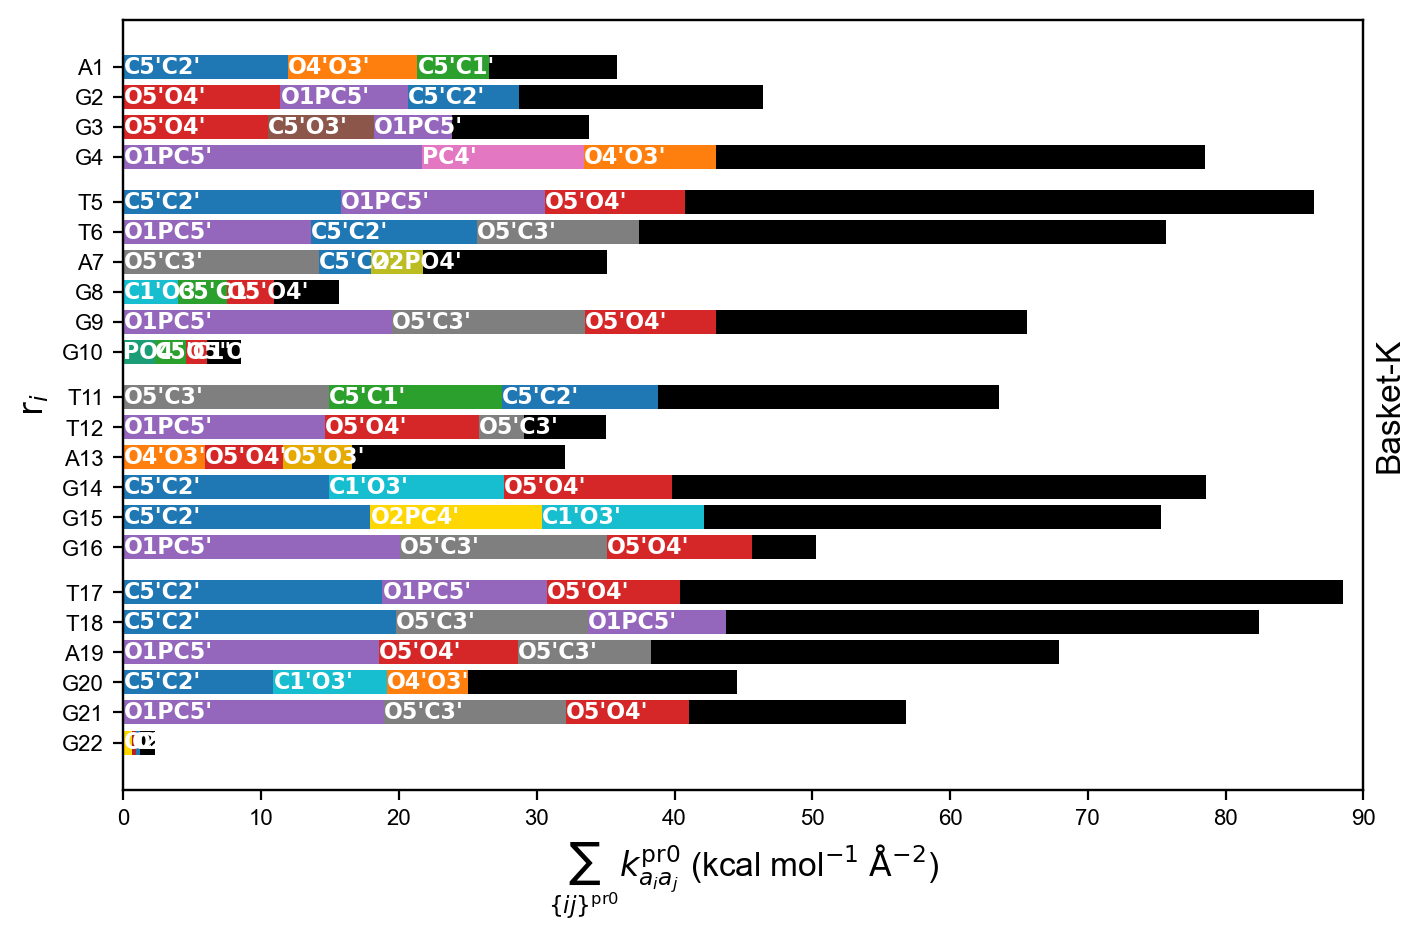

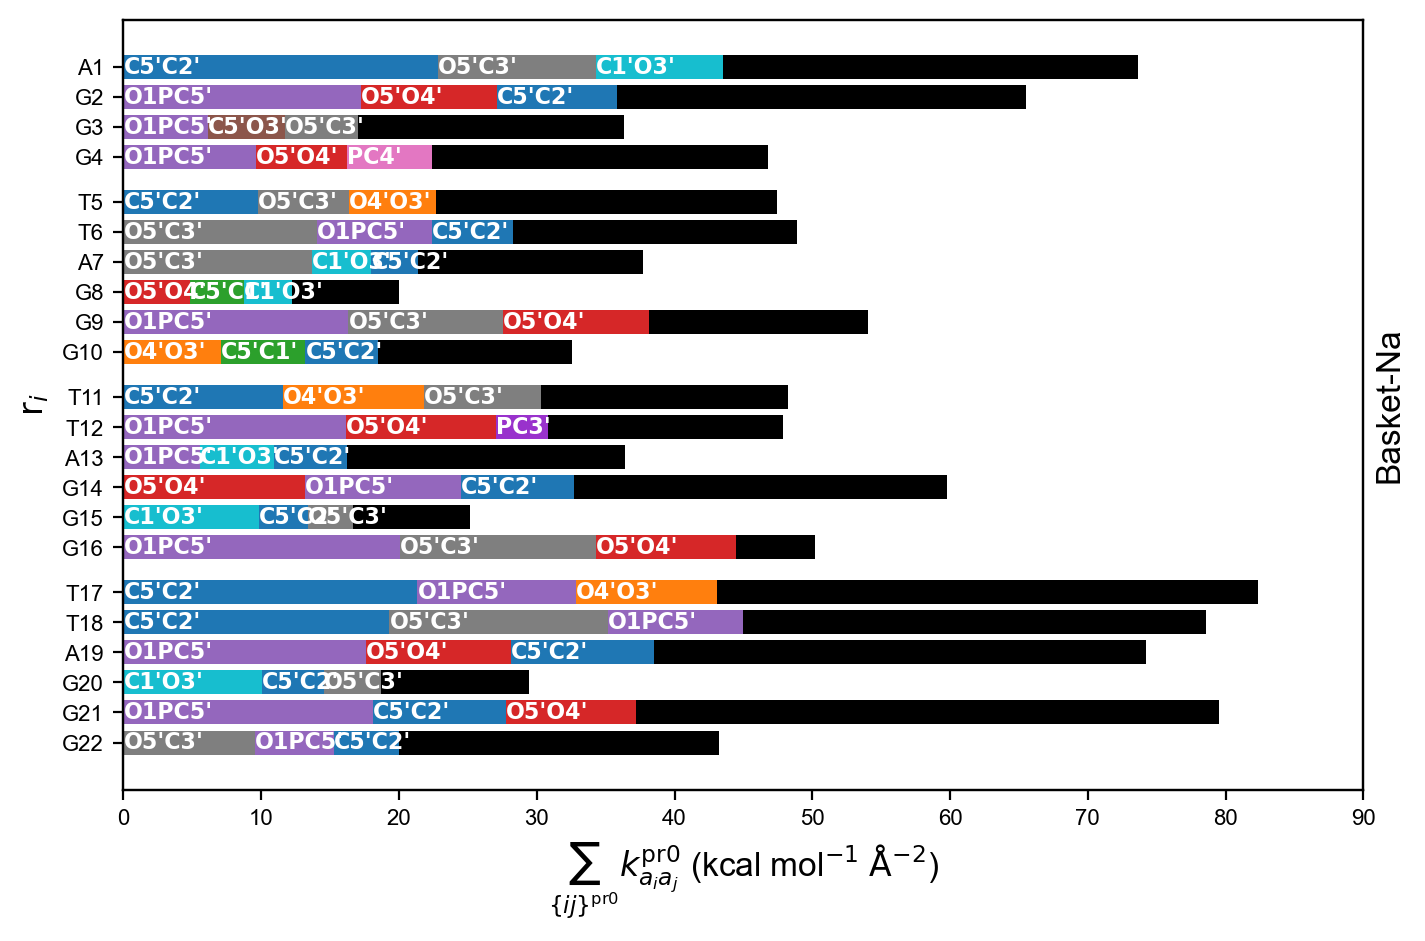

In [9]:
n_top = 3

aiaj2color = {}
for system, st_agent in hs_agent.items():
    p_agent = SinglePlotAgent(figsize_1=[8.0, 5.0])

    # Initialize left for each category
    n_repeat = (4,6)
    lefts = {rirj_str: 0 for rirj_str in st_agent.rirjs_str}
    yticks = np.arange(0.0, len(st_agent.rirjs_str))[::-1]
    for y in range(n_repeat[0], len(yticks), n_repeat[1]):
        yticks[:y] = yticks[:y] + 0.5
    rirj2ytick = dict(zip(st_agent.rirjs_str, yticks))

    # Sort the DataFrame by 'p' and 'k' (descending)
    df_sorted = st_agent.df_m.sort_values(by=['rirj', 'k'], ascending=[True, False])

    # Plot data
    for rirj_str in st_agent.rirjs_str:
        # Filter sorted data for the current category
        df_sele = df_sorted[df_sorted['rirj'] == rirj_str]
        # Plot each segment with the cumulative left position
        for i, (_, df_iter) in enumerate(df_sele.iterrows()):
            if i >= n_top: 
                aiaj = ''
                color = 'black'
            else:
                aiaj = df_iter['aiaj']
                color = aiaj2color.get(aiaj)
                if color is None:
                    color = palette[len(aiaj2color)]
                    aiaj2color[aiaj] = color
                    p_agent.axs.plot([], [], label=aiaj, c=color)
            ## barplot
            p_agent.axs.barh(rirj2ytick[df_iter['rirj']], df_iter['k'], left=lefts[rirj_str], color=color)
            ## text
            x = lefts[rirj_str]
            y = rirj2ytick[df_iter['rirj']]
            # print(df_iter['k'], x)
            p_agent.axs.text(x, y, aiaj, ha='left', va='center', c='white', rotation=0, 
                             size=8, fontweight='bold', alpha=1.0)
            # Update left position for the next segment
            lefts[rirj_str] += df_iter['k']
    # print(lefts)

    # Add labels, title, and legend
    p_agent.set_xlabel(r'$\sum_{\{ij\}^{\rm{'+hs_agent.m_abbr+r'}}} k^{\rm{'+hs_agent.m_abbr+'}}_{a_ia_j}$'+r' (kcal mol$^{-1}$ $\rm{\AA}^{-2}$)', fontdict={'family': 'Arial', 'weight': 'normal', 'size': 12})
    p_agent.axs.set_ylabel(r'${\rm{r}}_{i}$', fontdict={'family': 'Arial', 'weight':'normal', 'size': 12})
    p_agent.set_ylabel(st_agent.system_offical_name, position='right')
    xticks = range(0, 91, 10)
    p_agent.set_xticks(xticks, fontdict={'family': 'Arial', 'weight': 'normal', 'size': 8})
    p_agent.axs.set_yticks(yticks)
    p_agent.axs.set_yticklabels(st_agent.rirjs_str, fontdict={'family': 'Arial', 'weight': 'normal', 'size': 8})
    # p_agent.savefig(f'{hs_agent.m_abbr}_stacked_barplot.{st_agent.system_offical_name}.svg')